# Analyse du dataset AirPassengers

In [3]:
import pandas
import matplotlib.pyplot as plt


In [4]:
airpassengers = pandas.read_csv('AirPassengers.csv', index_col=0, parse_dates=True)
airpassengers.head()
airpassengers.tail()

Airpass
t                  
1960-08-01      606
1960-09-01      508
1960-10-01      461
1960-11-01      390
1960-12-01      432

In [5]:
import numpy

log_airpassengers = numpy.log(airpassengers)
log_airpassengers.tail()

Airpass
t                   
1960-08-01  6.406880
1960-09-01  6.230481
1960-10-01  6.133398
1960-11-01  5.966147
1960-12-01  6.068426

In [6]:
g, ax = plt.subplots()
ln1 = ax.plot(airpassengers, c='r', label='Nb passagers')
ax2 = ax.twinx()
ln2 = ax2.plot(log_airpassengers, c='b', label='Log nb passagers')
lns = ln1 + ln2
labels=[l.get_label() for l in lns]
ax.legend(lns, labels);

In [7]:
windows = list(range(3, 25, 3)) + [36]
fig = plt.figure(figsize=(12, 8))
for index, window in enumerate(windows, start=1):
    ax = fig.add_subplot(3, int(len(windows) / 3), index)
    ax.plot(log_airpassengers)
    ax.plot(log_airpassengers.rolling(window, center=True).mean(), label=f'Moyenne sur {window} mois')
    ax.legend()

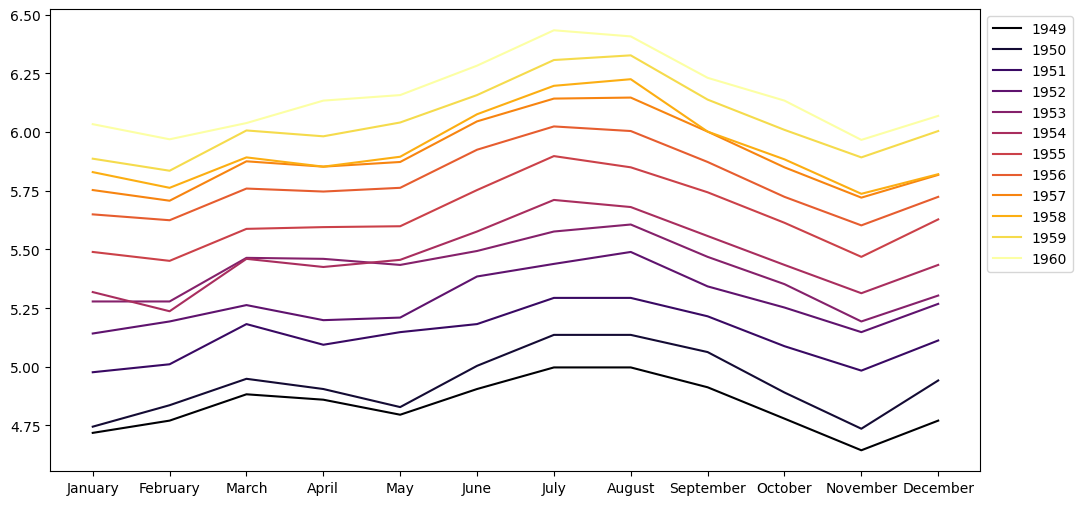

In [8]:
plt.figure(figsize=(12, 6))

years = [str(year) for year in log_airpassengers.index.year.unique()]
months = log_airpassengers.index.month_name().unique()
colors = plt.cm.inferno(numpy.linspace(0, 1, len(years)))

for index, year in enumerate(years):
    plt.plot(months, log_airpassengers.loc[year], label=year, color = colors[index])
    plt.legend(bbox_to_anchor=(1, 1))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomposed = seasonal_decompose(log_airpassengers, model='additive')

fig = decomposed.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

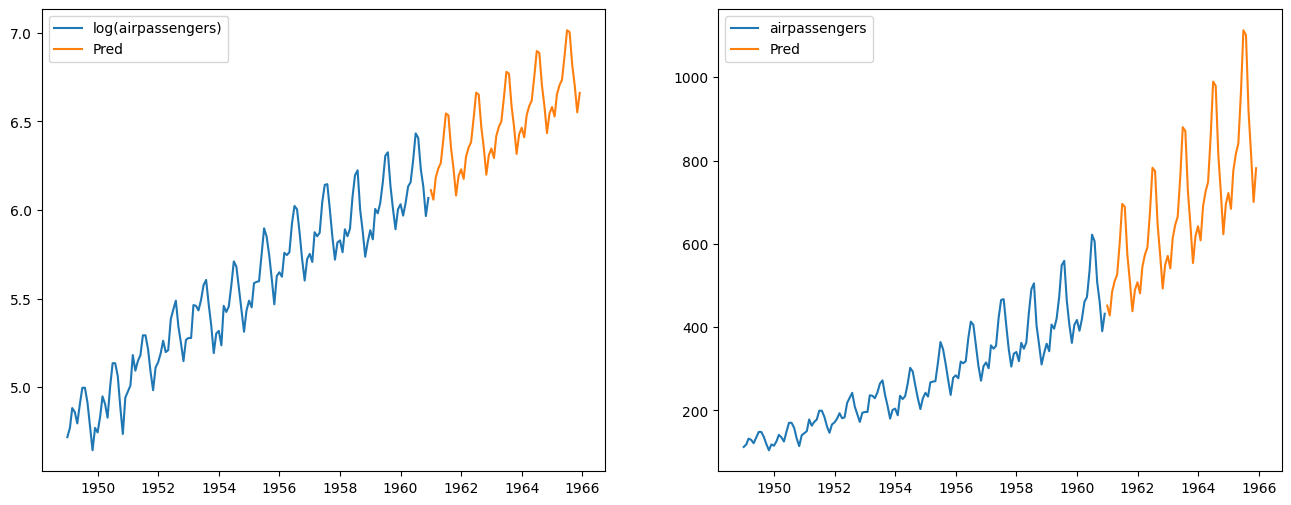

In [10]:
from statsmodels.tsa.api import ExponentialSmoothing

exp_smooth = ExponentialSmoothing(log_airpassengers.values, seasonal_periods=12, trend='add', seasonal='add').fit()

log_airpassengers_pred = exp_smooth.forecast(60)
airpassengers_pred = numpy.exp(exp_smooth.forecast(60))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(log_airpassengers, label='log(airpassengers)')
ax1.plot(pandas.date_range(log_airpassengers.index[- 1], periods=60, freq='ME'), log_airpassengers_pred, label='Pred')
ax1.legend()

ax2.plot(airpassengers, label='airpassengers')
ax2.plot(pandas.date_range(log_airpassengers.index[- 1], periods=60, freq='ME'), airpassengers_pred, label='Pred')
ax2.legend();

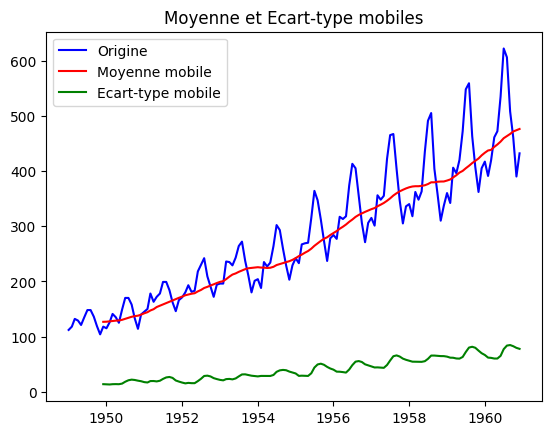

In [11]:
rolling_mean = airpassengers.rolling(window=12).mean()
rolling_std = airpassengers.rolling(window=12).std()

plt.plot(airpassengers, color='b', label='Origine')
plt.plot(rolling_mean, color='r', label='Moyenne mobile')
plt.plot(rolling_std, color='g', label='Ecart-type mobile')
plt.legend(loc='best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(airpassengers)
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 0.8153688792060498
p-value : 0.991880243437641
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


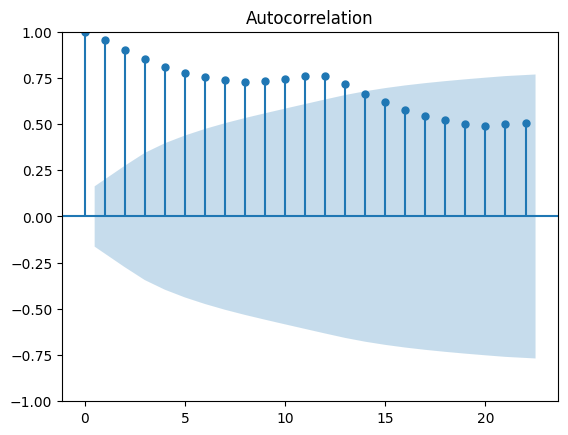

In [15]:
from statsmodels.tsa.api import graphics

graphics.plot_acf(log_airpassengers, lags=None);

In [16]:
def get_stationarity(timeseries, window=12):
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='b', label='Origine')
    mean = plt.plot(rolling_mean, color='r', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='g', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)

    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    graphics.plot_acf(timeseries, lags=None)

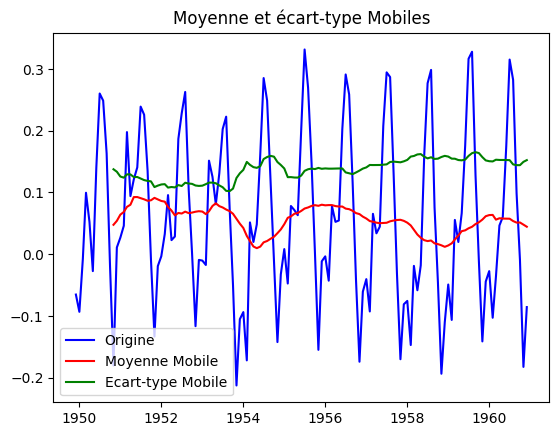

Statistiques ADF : -3.1629079913008833
p-value : 0.022234630001242206
Valeurs Critiques :
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


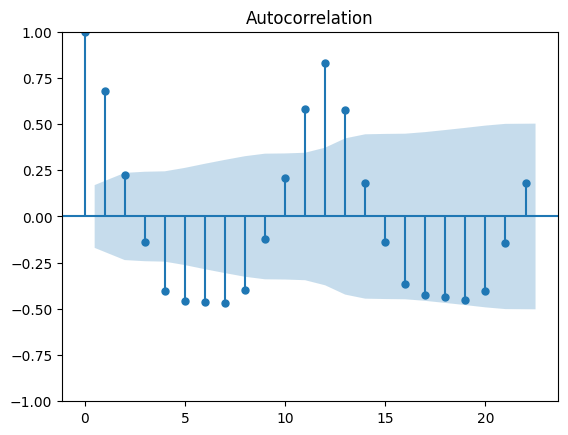

In [17]:
rolling_mean = log_airpassengers.rolling(window=12).mean()
df_log_minus_mean = log_airpassengers - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean, 12)


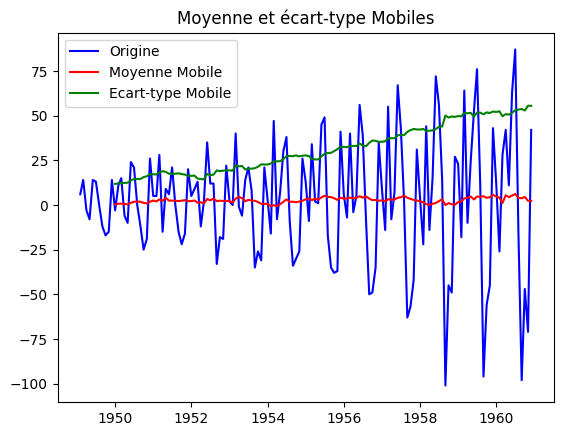

Statistiques ADF : -2.8292668241700047
p-value : 0.05421329028382478
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [20]:
differenced = airpassengers.diff().dropna()
get_stationarity(differenced, 12)

In [28]:
from statsmodels.tsa.api import graphics

def plot_acf_pacf(timeseries):
    fig = plt.figure(figsize=(12, 3))
    for index, (timeserie_title, timeserie) in enumerate(timeseries.items()):
        index = index * 2
        ax = fig.add_subplot(len(timeseries), 2, index + 1)
        ax.title.set_text(timeserie_title)
        graphics.plot_acf(timeserie, ax=ax)
        ax.title.set_text('ACF %s' % timeserie_title)

        ax = fig.add_subplot(len(timeseries), 2, index + 2)
        graphics.plot_pacf(timeserie, ax=ax)
        ax.title.set_text('PACF %s' % timeserie_title)

In [29]:
plot_acf_pacf({
    'DIFF': differenced

})

In [30]:
train_data = airpassengers[:-15]
test_data = airpassengers[-15:]

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Créer un modèle ARIMA(2,1,1)
model = ARIMA(train_data, order=(5,1,2), freq='MS')

# Ajuster le modèle
model_fit = model.fit()

# Afficher le résumé du modèle
print(model_fit.summary())

/home/sam/.local/share/virtualenvs/data_bachelor-EYLijImk/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Airpass   No. Observations:                  129
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -597.516
Date:                Wed, 15 May 2024   AIC                           1211.033
Time:                        13:51:55   BIC                           1233.849
Sample:                    01-01-1949   HQIC                          1220.303
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1942      0.183      1.061      0.289      -0.164       0.553
ar.L2          0.4181      0.101      4.143      0.000       0.220       0.616
ar.L3         -0.2621      0.108     -2.430      0.0

In [32]:
residuals = model_fit.resid
plot_acf_pacf({
    'Residue modèle': residuals
})

In [37]:
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Prédictions sur l'ensemble d'entraînement
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Tracer les prédictions et les données réelles avec les courbes collées
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Ensemble d\'entraînement', color='blue')
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(train_predictions.index, train_predictions, label='Prédictions (Entraînement)', color='red')
plt.plot(test_predictions.index, test_predictions, label='Prédictions (Test)', color='green')

# Définir les limites des axes x et y pour une continuité visuelle
#plt.xlim(train_data.index[0], test_data.index[-1])
#plt.ylim(min(train_data.min(), test_data.min()), max(train_data.max(), test_data.max()))

plt.xlabel('Date')
plt.ylabel('Passagers')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

In [38]:
import pmdarima as pm

# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = airpassengers[:-15]
test_data = airpassengers[-15:]

# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
model = pm.auto_arima(train_data)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -589.217
Date:                Wed, 15 May 2024   AIC                           1190.435
Time:                        13:54:21   BIC                           1207.547
Sample:                    01-01-1949   HQIC                          1197.388
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6605      0.126      5.239      0.000       0.413       0.908
ar.L1          1.6235      0.041     39.770      0.000       1.543       1.703
ar.L2         -0.8951      0.041    -21.896      0.0

In [42]:
import pmdarima as pm

# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = airpassengers[:-15]
test_data = airpassengers[-15:]

# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
#model = pm.auto_arima(train_data)
model = pm.auto_arima(train_data, seasonal=True, m=12)

print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  129
Model:             SARIMAX(2, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood                -429.985
Date:                                 Wed, 15 May 2024   AIC                            879.969
Time:                                         14:15:57   BIC                            907.591
Sample:                                     01-01-1949   HQIC                           891.183
                                          - 09-01-1959                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6671      3.225      0.207      0.836      -5.653       6

In [43]:
# Ajuster le modèle aux données
model.fit(train_data)
# Obtenir les résidus du modèle
residuals = model.resid()
plot_acf_pacf({
    'Residue modèle': residuals
})


In [44]:
# Faire des prédictions sur l'ensemble d'entraînement
train_pred, train_confint = model.predict_in_sample(return_conf_int=True)

# Faire des prédictions sur l'ensemble de test
n_periods = len(test_data)
predicted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Concaténer les prédictions pour l'ensemble d'entraînement et de test
all_predictions = pandas.concat([pandas.Series(train_pred, index=train_data.index),
                            pandas.Series(predicted, index=test_data.index)],
                            axis=0)

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Observed Training', color='blue')
plt.plot(test_data, label='Observed Test', color='green')
plt.plot(all_predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Observed vs Predicted Passengers')
plt.legend()
plt.grid(True)
plt.show()